<a href="https://colab.research.google.com/github/marinasr00/TADM/blob/main/Copia_de_TADM2022_2a_Razonamiento_Borroso_(Oficial).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Sistema Borroso
 

Vamos a crear un sistema de control borroso que modela cómo se puede evaluar la capacidad de un cliente para pedir un préstamo. Cuando se tiene que dar un préstamos se considerará la edad del peticionario, la cantidad del préstamos, la duración y los pagos en los que se divide. FInalmente nos dará una puntuación de 0 a 10 al préstamo. 


## Preliminares

https://pythonhosted.org/scikit-fuzzy/auto_examples/plot_tipping_problem_newapi.html#example-plot-tipping-problem-newapi-py

* instalación de scikit-fuzzy

In [ ]:
# https://pythonhosted.org/scikit-fuzzy/
!pip install -U scikit-fuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 993 kB 7.3 MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894088 sha256=845888a43c3e216a624a7cebc2921e56fe187be2bff6fe276f832b1d3a7631c4
  Stored in directory: /root/.cache/pip/wheels/d5/74/fc/38588a3d2e3f34f74588e6daa3aa5b0a322bd6f9420a707131
Successfully built scikit-fuzzy


* importación de librerías


In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

Puede generalizarse
de forma que los valores asignados a los elementos del conjunto caigan en un rango
particular y con ello indiquen el grado de pertenencia de los elementos al conjunto en cuestión. Esta función se llama función de pertenencia y el conjunto por ella definida es el conjunto borroso.

##  Sistema Borroso

Definimos los Antecedentes
* Edad del cliente
* pagos mensuales
* Cantidad del Préstamo
* Duración de la Amortización (min: 12 max 60)



Cada variable que interviene como hipótesis en una regla tiene asociado un
dominio. Cada dominio puede estar dividido en tantos conjuntos borrosos como
el experto considere oportuno. Cada una de estas particiones tiene asociada una
*etiqueta lingüística*.

Para definir el rango de la función se utliza *np.arange*.


1. Pagos mensuales

En este caso, el número de etiquetas será 3. Por tanto, siempre se pondrá el nombre, el dominio o rango y el número de etiquetas. Finalmente, el view nos sacará una serie de etiquetas (en este caso; good, average y poor).

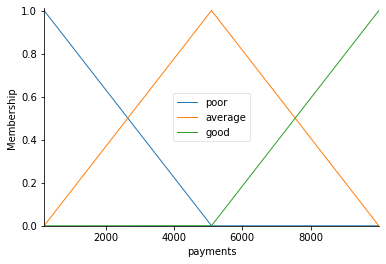

In [ ]:
payments = ctrl.Antecedent(np.arange(200, 10000, 1), 'payments')
payments.automf(3)
payments.view()

Otra alternativa sería definiendo las etiquetas lingüísticas:

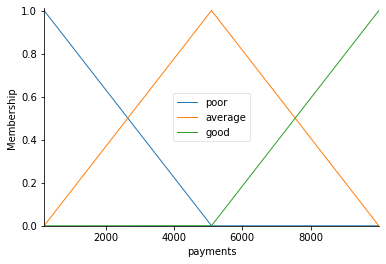

In [ ]:
payments = ctrl.Antecedent(np.arange(200, 10000, 1), 'payments')
payments.automf(3, names = ["poor", "average","good"])
payments.view()

Son convexas, normalizadas y nos representa claramente el universo del concurso. 
Representa como los pagos son pobres hasta los 5.000€ y a partir de estos, son buenos.

2. Edad del cliente

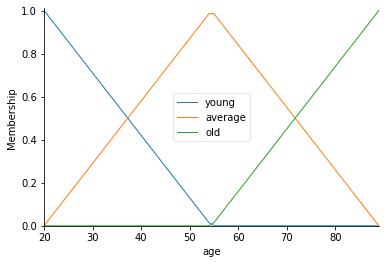

In [ ]:
age = ctrl.Antecedent(np.arange(20,90, 1), 'age')
age.automf(3, names = ["young", "average", "old"])
age.view()

Hasta los 55 años la población se considera joven y a partir de este mayor.

3. Duración de la amortización (mín. 20 y máx. 60)

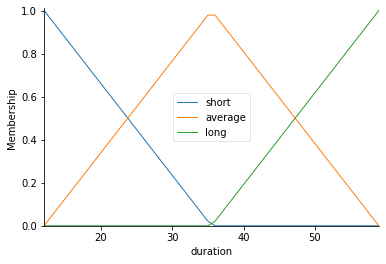

In [ ]:
duration = ctrl.Antecedent(np.arange(12, 60, 1), 'duration')
duration.automf(3, names=["short", "average", "long"])
duration.view()

Hasta los 35 años, se considera una amortización corta, mientras que a partir de esta se consideraría larga.

4. Cantidad del préstamo

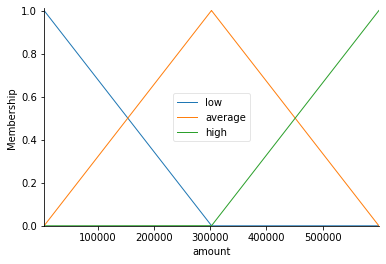

In [ ]:
amount = ctrl.Antecedent(np.arange(5000, 600000, 1), 'amount')
amount.automf(3,  names = ["low","average","high"])
amount.view()

Hasta los 300.000€ es un préstamos bajo y a partir de esa cantidad es alto.

Definimos el consecuente

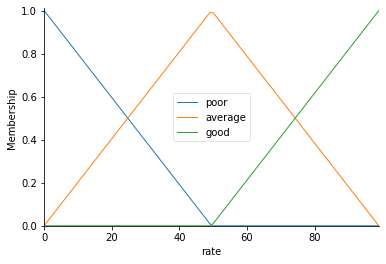

In [ ]:
rate = ctrl.Consequent(np.arange(0, 100, 1), 'rate')
rate.automf(3)
rate.view()


El consecuente es utilizado para definir como queremos que nos mida las variables salida.

## Reglas borrosas
-----------
Ahora, para hacer estos triángulos útiles, definimos la *relación borrosa*
entre las variables de entrada y salida. Para el ejemplo vamos a considerar las siguientes reglas simples (para hacer un sistema completo se necesitarían algunas más) 

1. Si la duración y la cantidad son pequeñas entonces la calificación será buena.
2. Si la cantidad es alta, los pagos pequeños y la duración alta entonces la calificación será *pobre*
3. Si la cantidad es media y los pagos también medios si la edad del cliente es baja entonces el rating es medio. 

La clave de estas reglas es que son borrosas, es decir que expresamos la información de forma lingüística intentando manejar la incertidumbre inherente. 



Se definen las reglas: se pone el nombre, la etiqueta, el antecendente de la regla y el nombre de la variable salida y su antecedente.
El segundo campo es la salida. 

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3e730673d0>)

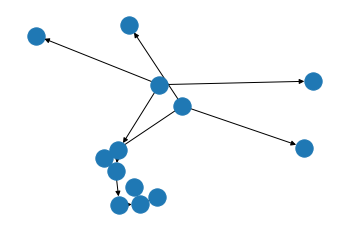

In [ ]:
rule1 = ctrl.Rule(duration['short'] & amount['low'], rate['good'])
rule2 = ctrl.Rule(amount['high'] & payments['average'] & duration["long"], rate["poor"])
rule3 = ctrl.Rule(age['young'] & amount['average'], rate['average'])

rule1.view()

Ahora que tenemos nuestras reglas definidas, podemos simplemente crear un sistema de control vía:

Se acumulan las reglas a partir de un sistema de reglas:

In [ ]:
rating_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
rating_ctrl.graph

Con el fin de simular este sistema de control, crearemos un
"Sistema de Control y Simulación".  Este objeto que representa al controlador aplicado a un conjunto específico de circunstancias.  

In [ ]:
rating = ctrl.ControlSystemSimulation(rating_ctrl)

Ahora podemos simular nuestro sistema de control simplemente especificando las entradas y llamando al método *compute*.  

*Por ejemplo* : Supongamos que un cliente de 40 años va a pedir un préstamos a 12 años con pagos de 2000 y una cantidad de 300000

Entrada:

In [ ]:
rating.input['age'] = 30
rating.input['duration'] = 60
rating.input['payments'] = 2000
rating.input['amount'] = 500000


Escalas de salida:

44.52999446644107


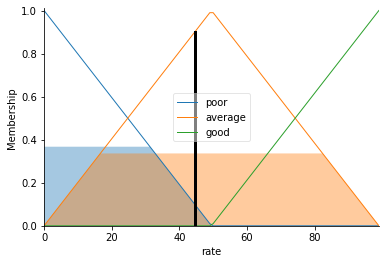

In [ ]:
rating.compute()
print(rating.output['rate'])
rate.view(sim=rating)

El sombreado azul indica que la pertenencia es pobre, una cercana al 0.3 es lo que me ha dado average y a partir de las areas que terminan estas reglas me defino cual está en la media o la mediana. 


En este caso, la cantidad es media, los pagos también medios y la edad del cliente es baja entonces el rating será medio (AVERAGE), aunque también hay posibilidad de que se posicione tanto en pobre como en bueno, por eso, se denomina "borroso".

44.52 será el centro de gravedad de nuestro sistema.